<a href="https://colab.research.google.com/github/SattuSupCodes/SentimentAnalysis_TheoreticalLearning/blob/main/diarisation_gender_basis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans #from here we start out unsupervised checkpoint
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/cremad")
# ADDING MORE DATASETS TO ADD DYNAMICS LETS GO
print("Path to dataset files:", path)

100%|██████████| 451M/451M [00:03<00:00, 129MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ejlok1/cremad/versions/1


# Understanding How Crema-D Dataset Works

eg: 1001_TSI_SAD_XX.wav is actually the format [ActorID]_[Sentence]_[Emotion]_[Intensity].wav
 the CREMA-D is a very good dataset to use to ensure the model does not overfit. (Like what happened with our RAVDESS data here)

 # Gender

 CREMA-D uses actorID metadata to map gender.
 WE MUST USE THIS METADATA ONLY.



In [28]:
import os
os.listdir(path)


['AudioWAV']

# UHM...
 Nevermind, kaggle seems to have made some tweaks and the gender labels aren't there anymore so...

 # WE SWITCH FROM SUPERVISED -> UNSUPERVISED
 DO I HEAR EXTRA CHALLENGE? LETS GO

In [ ]:
# from google.colab import drive

# drive.mount('/content/drive')


Mounted at /content/drive


In [23]:
# os.listdir('/content/drive/MyDrive/ravdess')

In [15]:
base_path = "/content/drive/MyDrive/ravdess/audio_speech_actors_01-24"


In [25]:
# os.listdir(base_path)


In [36]:
def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    return np.concatenate([mfcc_mean, mfcc_std])


In [37]:
X = []
y = []

for actor in os.listdir(base_path):
    actor_path = os.path.join(base_path, actor)

    if not os.path.isdir(actor_path):
        continue

    actor_id = int(actor.split("_")[1])

    gender_label = 1 if actor_id % 2 == 0 else 0  # 1=female, 0=male

    for file in os.listdir(actor_path):
        if file.endswith(".wav"):
            file_path = os.path.join(actor_path, file)
            features = extract_mfcc(file_path)

            X.append(features)
            y.append(gender_label)


In [39]:
crema_audio_path = os.path.join(path, "AudioWAV")


# Extracting CREMA-D

In [44]:
X_crema = []
files_crema = []

for file in os.listdir(crema_audio_path):
    if file.endswith(".wav"):
        fp = os.path.join(crema_audio_path, file)
        X_crema.append(extract_mfcc(fp))
        files_crema.append(file)

X_crema = np.array(X_crema)
print("CREMA features:", X_crema.shape)

CREMA features: (7442, 26)


In [18]:
X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Male samples:", np.sum(y == 0))
print("Female samples:", np.sum(y == 1))


X shape: (1440, 26)
y shape: (1440,)
Male samples: 720
Female samples: 720


In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [41]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_crema_scaled = scaler.transform(X_crema)


In [42]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters_crema = kmeans.fit_predict(X_crema_scaled)

In [45]:
import numpy as np
np.unique(clusters_crema, return_counts=True)


(array([0, 1], dtype=int32), array([4977, 2465]))

In [46]:
pitches = []

for file in files_crema:
    y, sr = librosa.load(
        os.path.join(crema_audio_path, file),
        sr=16000
    )
    f0 = librosa.yin(y, fmin=50, fmax=300, sr=sr)
    pitches.append(np.nanmean(f0))

pitches = np.array(pitches)


In [47]:
import pandas as pd

df = pd.DataFrame({
    "cluster": clusters_crema,
    "pitch": pitches
})

df.groupby("cluster")["pitch"].mean()


,pitch
cluster,
0,142.34224
1,167.60016


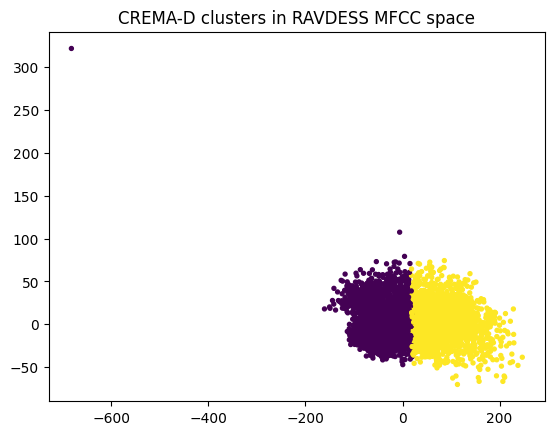

In [49]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_crema_scaled)

plt.scatter(X_2d[:,0], X_2d[:,1], c=clusters_crema, s=8)
plt.title("CREMA-D clusters in RAVDESS MFCC space")
plt.show()

In [21]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9965277777777778
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       144
           1       0.99      1.00      1.00       144

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288



In [22]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[143   1]
 [  0 144]]


In [26]:
np.bincount(y)


array([720, 720])

# Too Accurate?
don't get happy, our dataset is too good. That's it. (sorry for bursting our bubble) [CHECKPOINT WHRE WE USED ONLY RAVDESS]